## Import necessary libraries

In [1]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri



from scipy.optimize import least_squares
from tomlkit import boolean
from tqdm import tqdm


## image preprocessing 

In [2]:

def preprocess_image(image_path):
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Return the original and grayscale images
    return image, gray_image

In [3]:
# Define a function for structure from motion
def structure_from_motion(images):
    # List to store the reconstructed 3D points
    reconstructed_3d_points = []

    # Loop through each image in the provided list
    for idx, img in enumerate(images):
        # Detect good features to track in the image
        corners = cv2.goodFeaturesToTrack(img, maxCorners=200, qualityLevel=0.001, minDistance=20)

        # Check if no corners are detected in the current image
        if corners is None:
            print(f"No corners detected in image {idx}")
            continue

        # Set the object height and initial depth
        object_height = 1.0
        depth = object_height
        
        # Create 3D points with X, Y, and Z coordinates
        points_3d = np.column_stack((corners[:, 0, 0], corners[:, 0, 1], np.full_like(corners[:, 0, 0], depth)))

        # Append the 3D points to the list
        reconstructed_3d_points.append(points_3d)

        # Visualize detected corners in the current image
        plt.imshow(img, cmap='gray')
        plt.scatter(corners[:, 0, 0], corners[:, 0, 1], c='r', marker='o')
        plt.title(f"Detected Corners in Image {idx}")
        plt.show()

    # Check if no 3D points were reconstructed
    if not reconstructed_3d_points:
        print("No 3D points were reconstructed. Check your feature detection parameters.")
        return

    # Visualize the reconstructed 3D points in a 3D plot
    reconstructed_3d_points = np.vstack(reconstructed_3d_points)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(reconstructed_3d_points[:, 0], reconstructed_3d_points[:, 1], reconstructed_3d_points[:, 2], c='b', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Reconstructed 3D Points from the 2D images')
    plt.show()

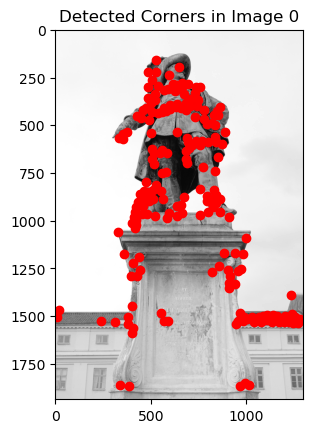

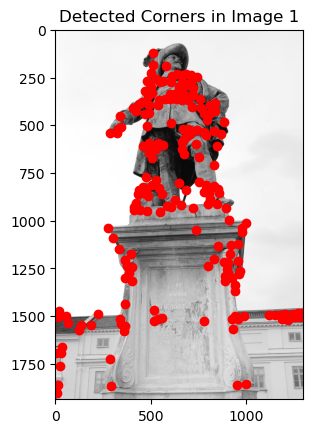

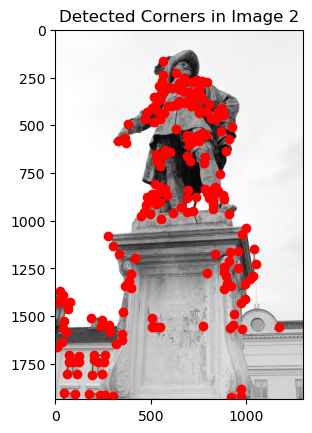

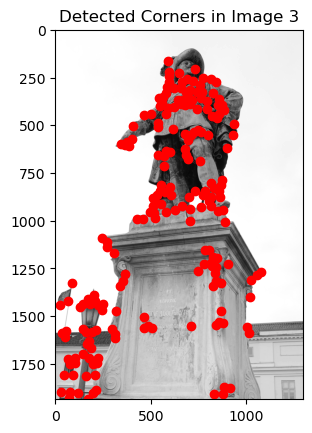

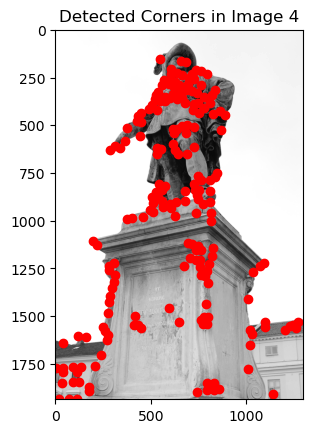

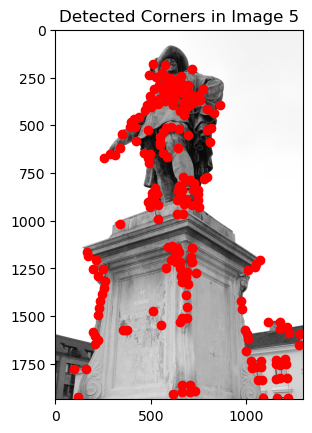

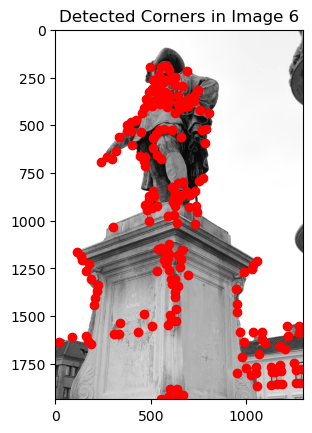

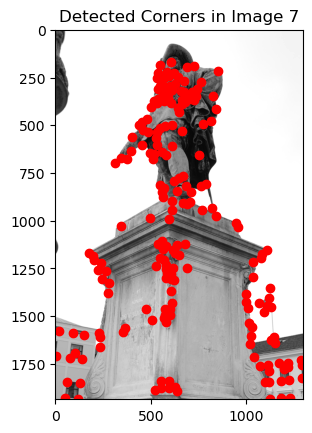

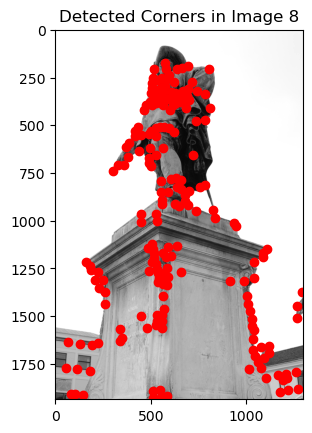

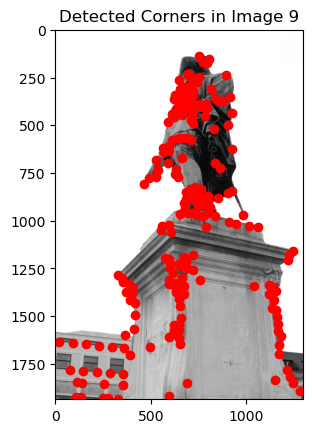

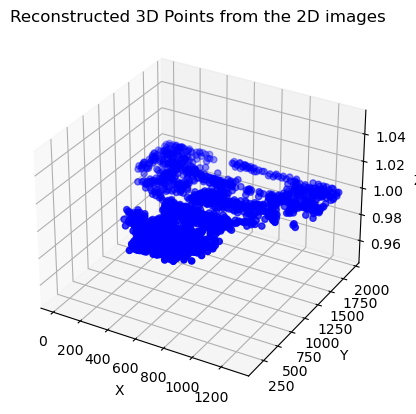

In [4]:
def main():
    
    image_path1 = 'Datasets\\GustavIIAdolf\\DSC_0351.JPG'
    image_path2 = 'Datasets\\GustavIIAdolf\\DSC_0352.JPG'
    image_path3 = 'Datasets\\GustavIIAdolf\\DSC_0353.JPG'
    image_path4 = 'Datasets\\GustavIIAdolf\\DSC_0354.JPG'
    image_path5 = 'Datasets\\GustavIIAdolf\\DSC_0355.JPG'
    image_path6 = 'Datasets\\GustavIIAdolf\\DSC_0356.JPG'
    image_path7 = 'Datasets\\GustavIIAdolf\\DSC_0357.JPG'
    image_path8 = 'Datasets\\GustavIIAdolf\\DSC_0358.JPG'
    image_path9 = 'Datasets\\GustavIIAdolf\\DSC_0359.JPG'
    image_path10 = 'Datasets\\GustavIIAdolf\\DSC_0360.JPG'
    

    _, gray_img1 = preprocess_image(image_path1)
    _, gray_img2 = preprocess_image(image_path2)
    _, gray_img3 = preprocess_image(image_path3)
    _, gray_img4 = preprocess_image(image_path4)
    _, gray_img5 = preprocess_image(image_path5)
    _, gray_img6 = preprocess_image(image_path6)
    _, gray_img7 = preprocess_image(image_path7)
    _, gray_img8 = preprocess_image(image_path8)
    _, gray_img9 = preprocess_image(image_path9)
    _, gray_img10 = preprocess_image(image_path10)
    

    # Structure from Motion
    structure_from_motion([gray_img1, gray_img2, gray_img3, gray_img4, gray_img5, gray_img6, gray_img7, gray_img8, gray_img9, gray_img10])
    
if __name__ == "__main__":
    main()


In [5]:
class Image_loader():
    def __init__(self, img_dir:str, downscale_factor:float):
        # loading the Camera intrinsic parameters K
        with open(img_dir + '\\K.txt') as f:
            self.K = np.array(list((map(lambda x:list(map(lambda x:float(x), x.strip().split(' '))),f.read().split('\n')))))
            self.image_list = []
        # Loading the set of images
        for image in sorted(os.listdir(img_dir)):
            if image[-4:].lower() == '.jpg' or image[-5:].lower() == '.png':
                self.image_list.append(img_dir + '\\' + image)
        
        self.path = os.getcwd()
        self.factor = downscale_factor
        self.downscale()

    
    def downscale(self) -> None:
        
        self.K[0, 0] /= self.factor
        self.K[1, 1] /= self.factor
        self.K[0, 2] /= self.factor
        self.K[1, 2] /= self.factor
    
    def downscale_image(self, image):
        for _ in range(1,int(self.factor / 2) + 1):
            image = cv2.pyrDown(image)
        return image

In [6]:

class Sfm():
    def __init__(self, img_dir:str, downscale_factor:float = 2.0) -> None:
        '''
            Initialise and Sfm object.
        '''
        self.img_obj = Image_loader(img_dir,downscale_factor)

    def triangulation(self, point_2d_1, point_2d_2, projection_matrix_1, projection_matrix_2) -> tuple:
        
        pt_cloud = cv2.triangulatePoints(point_2d_1, point_2d_2, projection_matrix_1.T, projection_matrix_2.T)
        return projection_matrix_1.T, projection_matrix_2.T, (pt_cloud / pt_cloud[3])    
    
    def PnP(self, obj_point, image_point , K, dist_coeff, rot_vector, initial) ->  tuple:
       
        if initial == 1:
            obj_point = obj_point[:, 0 ,:]
            image_point = image_point.T
            rot_vector = rot_vector.T 
        _, rot_vector_calc, tran_vector, inlier = cv2.solvePnPRansac(obj_point, image_point, K, dist_coeff, cv2.SOLVEPNP_ITERATIVE)
        # Converts a rotation matrix to a rotation vector or vice versa
        rot_matrix, _ = cv2.Rodrigues(rot_vector_calc)

        if inlier is not None:
            image_point = image_point[inlier[:, 0]]
            obj_point = obj_point[inlier[:, 0]]
            rot_vector = rot_vector[inlier[:, 0]]
        return rot_matrix, tran_vector, image_point, obj_point, rot_vector
    
    def reprojection_error(self, obj_points, image_points, transform_matrix, K, homogenity) ->tuple:
        
        rot_matrix = transform_matrix[:3, :3]
        tran_vector = transform_matrix[:3, 3]
        rot_vector, _ = cv2.Rodrigues(rot_matrix)
        if homogenity == 1:
            obj_points = cv2.convertPointsFromHomogeneous(obj_points.T)
        image_points_calc, _ = cv2.projectPoints(obj_points, rot_vector, tran_vector, K, None)
        image_points_calc = np.float32(image_points_calc[:, 0, :])
        total_error = cv2.norm(image_points_calc, np.float32(image_points.T) if homogenity == 1 else np.float32(image_points), cv2.NORM_L2)
        return total_error / len(image_points_calc), obj_points

    def optimal_reprojection_error(self, obj_points) -> np.array:
        
        transform_matrix = obj_points[0:12].reshape((3,4))
        K = obj_points[12:21].reshape((3,3))
        rest = int(len(obj_points[21:]) * 0.4)
        p = obj_points[21:21 + rest].reshape((2, int(rest/2))).T
        obj_points = obj_points[21 + rest:].reshape((int(len(obj_points[21 + rest:])/3), 3))
        rot_matrix = transform_matrix[:3, :3]
        tran_vector = transform_matrix[:3, 3]
        rot_vector, _ = cv2.Rodrigues(rot_matrix)
        image_points, _ = cv2.projectPoints(obj_points, rot_vector, tran_vector, K, None)
        image_points = image_points[:, 0, :]
        error = [ (p[idx] - image_points[idx])**2 for idx in range(len(p))]
        return np.array(error).ravel()/len(p)

    def bundle_adjustment(self, _3d_point, opt, transform_matrix_new, K, r_error) -> tuple:
        
        opt_variables = np.hstack((transform_matrix_new.ravel(), K.ravel()))
        opt_variables = np.hstack((opt_variables, opt.ravel()))
        opt_variables = np.hstack((opt_variables, _3d_point.ravel()))

        values_corrected = least_squares(self.optimal_reprojection_error, opt_variables, gtol = r_error).x
        K = values_corrected[12:21].reshape((3,3))
        rest = int(len(values_corrected[21:]) * 0.4)
        return values_corrected[21 + rest:].reshape((int(len(values_corrected[21 + rest:])/3), 3)), values_corrected[21:21 + rest].reshape((2, int(rest/2))).T, values_corrected[0:12].reshape((3,4))

    def to_ply(self, path, point_cloud, colors) -> None:
        
        out_points = point_cloud.reshape(-1, 3) * 200
        out_colors = colors.reshape(-1, 3)
        print(out_colors.shape, out_points.shape)
        verts = np.hstack([out_points, out_colors])


        mean = np.mean(verts[:, :3], axis=0)
        scaled_verts = verts[:, :3] - mean
        dist = np.sqrt(scaled_verts[:, 0] ** 2 + scaled_verts[:, 1] ** 2 + scaled_verts[:, 2] ** 2)
        indx = np.where(dist < np.mean(dist) + 300)
        verts = verts[indx]
        ply_header = '''ply
            format ascii 1.0
            element vertex %(vert_num)d
            property float x
            property float y
            property float z
            property uchar blue
            property uchar green
            property uchar red
            end_header
            '''
        with open(path + '\\res\\' + self.img_obj.image_list[0].split('\\')[-2] + '.ply', 'w') as f:
            f.write(ply_header % dict(vert_num=len(verts)))
            np.savetxt(f, verts, '%f %f %f %d %d %d')


    def common_points(self, image_points_1, image_points_2, image_points_3) -> tuple:
        
        cm_points_1 = []
        cm_points_2 = []
        for i in range(image_points_1.shape[0]):
            a = np.where(image_points_2 == image_points_1[i, :])
            if a[0].size != 0:
                cm_points_1.append(i)
                cm_points_2.append(a[0][0])

        mask_array_1 = np.ma.array(image_points_2, mask=False)
        mask_array_1.mask[cm_points_2] = True
        mask_array_1 = mask_array_1.compressed()
        mask_array_1 = mask_array_1.reshape(int(mask_array_1.shape[0] / 2), 2)

        mask_array_2 = np.ma.array(image_points_3, mask=False)
        mask_array_2.mask[cm_points_2] = True
        mask_array_2 = mask_array_2.compressed()
        mask_array_2 = mask_array_2.reshape(int(mask_array_2.shape[0] / 2), 2)
        print(" Shape New Array", mask_array_1.shape, mask_array_2.shape)
        return np.array(cm_points_1), np.array(cm_points_2), mask_array_1, mask_array_2


    def find_features(self, image_0, image_1) -> tuple:
        

        sift = cv2.SIFT_create()
        key_points_0, desc_0 = sift.detectAndCompute(cv2.cvtColor(image_0, cv2.COLOR_BGR2GRAY), None)
        key_points_1, desc_1 = sift.detectAndCompute(cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY), None)

        bf = cv2.BFMatcher()
        matches = bf.knnMatch(desc_0, desc_1, k=2)
        feature = []
        for m, n in matches:
            if m.distance < 0.70 * n.distance:
                feature.append(m)

        return np.float32([key_points_0[m.queryIdx].pt for m in feature]), np.float32([key_points_1[m.trainIdx].pt for m in feature])

    def __call__(self, enable_bundle_adjustment:boolean=False):
        cv2.namedWindow('image', cv2.WINDOW_NORMAL)
        pose_array = self.img_obj.K.ravel()
        transform_matrix_0 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
        transform_matrix_1 = np.empty((3, 4))
    
        pose_0 = np.matmul(self.img_obj.K, transform_matrix_0)
        pose_1 = np.empty((3, 4)) 
        total_points = np.zeros((1, 3))
        total_colors = np.zeros((1, 3))

        image_0 = self.img_obj.downscale_image(cv2.imread(self.img_obj.image_list[0]))
        image_1 = self.img_obj.downscale_image(cv2.imread(self.img_obj.image_list[1]))

        feature_0, feature_1 = self.find_features(image_0, image_1)

        # Essential matrix
        essential_matrix, em_mask = cv2.findEssentialMat(feature_0, feature_1, self.img_obj.K, method=cv2.RANSAC, prob=0.999, threshold=0.4, mask=None)
        feature_0 = feature_0[em_mask.ravel() == 1]
        feature_1 = feature_1[em_mask.ravel() == 1]


        _, rot_matrix, tran_matrix, em_mask = cv2.recoverPose(essential_matrix, feature_0, feature_1, self.img_obj.K)
        feature_0 = feature_0[em_mask.ravel() > 0]
        feature_1 = feature_1[em_mask.ravel() > 0]
        transform_matrix_1[:3, :3] = np.matmul(rot_matrix, transform_matrix_0[:3, :3])
        transform_matrix_1[:3, 3] = transform_matrix_0[:3, 3] + np.matmul(transform_matrix_0[:3, :3], tran_matrix.ravel())

        pose_1 = np.matmul(self.img_obj.K, transform_matrix_1)

        feature_0, feature_1, points_3d = self.triangulation(pose_0, pose_1, feature_0, feature_1)
        error, points_3d = self.reprojection_error(points_3d, feature_1, transform_matrix_1, self.img_obj.K, homogenity = 1)
        #ideally error < 1
        print("REPROJECTION ERROR: ", error)
        _, _, feature_1, points_3d, _ = self.PnP(points_3d, feature_1, self.img_obj.K, np.zeros((5, 1), dtype=np.float32), feature_0, initial=1)

        total_images = len(self.img_obj.image_list) - 2 
        pose_array = np.hstack((np.hstack((pose_array, pose_0.ravel())), pose_1.ravel()))

        threshold = 0.5
        for i in tqdm(range(total_images)):
            image_2 = self.img_obj.downscale_image(cv2.imread(self.img_obj.image_list[i + 2]))
            features_cur, features_2 = self.find_features(image_1, image_2)

            if i != 0:
                feature_0, feature_1, points_3d = self.triangulation(pose_0, pose_1, feature_0, feature_1)
                feature_1 = feature_1.T
                points_3d = cv2.convertPointsFromHomogeneous(points_3d.T)
                points_3d = points_3d[:, 0, :]
            

            cm_points_0, cm_points_1, cm_mask_0, cm_mask_1 = self.common_points(feature_1, features_cur, features_2)
            cm_points_2 = features_2[cm_points_1]
            cm_points_cur = features_cur[cm_points_1]

            rot_matrix, tran_matrix, cm_points_2, points_3d, cm_points_cur = self.PnP(points_3d[cm_points_0], cm_points_2, self.img_obj.K, np.zeros((5, 1), dtype=np.float32), cm_points_cur, initial = 0)
            transform_matrix_1 = np.hstack((rot_matrix, tran_matrix))
            pose_2 = np.matmul(self.img_obj.K, transform_matrix_1)

            error, points_3d = self.reprojection_error(points_3d, cm_points_2, transform_matrix_1, self.img_obj.K, homogenity = 0)
        
            
            cm_mask_0, cm_mask_1, points_3d = self.triangulation(pose_1, pose_2, cm_mask_0, cm_mask_1)
            error, points_3d = self.reprojection_error(points_3d, cm_mask_1, transform_matrix_1, self.img_obj.K, homogenity = 1)
            print("Reprojection Error: ", error)
            pose_array = np.hstack((pose_array, pose_2.ravel()))
            # takes a long time to run
            if enable_bundle_adjustment:
                points_3d, cm_mask_1, transform_matrix_1 = self.bundle_adjustment(points_3d, cm_mask_1, transform_matrix_1, self.img_obj.K, threshold)
                pose_2 = np.matmul(self.img_obj.K, transform_matrix_1)
                error, points_3d = self.reprojection_error(points_3d, cm_mask_1, transform_matrix_1, self.img_obj.K, homogenity = 0)
                print("Bundle Adjusted error: ",error)
                total_points = np.vstack((total_points, points_3d))
                points_left = np.array(cm_mask_1, dtype=np.int32)
                color_vector = np.array([image_2[l[1], l[0]] for l in points_left])
                total_colors = np.vstack((total_colors, color_vector))
            else:
                total_points = np.vstack((total_points, points_3d[:, 0, :]))
                points_left = np.array(cm_mask_1, dtype=np.int32)
                color_vector = np.array([image_2[l[1], l[0]] for l in points_left.T])
                total_colors = np.vstack((total_colors, color_vector)) 
   


            transform_matrix_0 = np.copy(transform_matrix_1)
            pose_0 = np.copy(pose_1)
            plt.scatter(i, error)
            plt.pause(0.05)

            image_0 = np.copy(image_1)
            image_1 = np.copy(image_2)
            feature_0 = np.copy(features_cur)
            feature_1 = np.copy(features_2)
            pose_1 = np.copy(pose_2)
            cv2.imshow(self.img_obj.image_list[0].split('\\')[-2], image_2)
            if cv2.waitKey(1) & 0xff == ord('q'):
                break
        cv2.destroyAllWindows()

        print("Printing to .ply file")
        print(total_points.shape, total_colors.shape)
        self.to_ply(self.img_obj.path, total_points, total_colors)
        print("Completed Exiting ...")
        np.savetxt(self.img_obj.path + '\\res\\' + self.img_obj.image_list[0].split('\\')[-2]+'_pose_array.csv', pose_array, delimiter = '\n')



REPROJECTION ERROR:  0.003916997202367769


  0%|                                                                                           | 0/55 [00:00<?, ?it/s]

 Shape New Array (558, 2) (558, 2)
Reprojection Error:  0.172329245791876


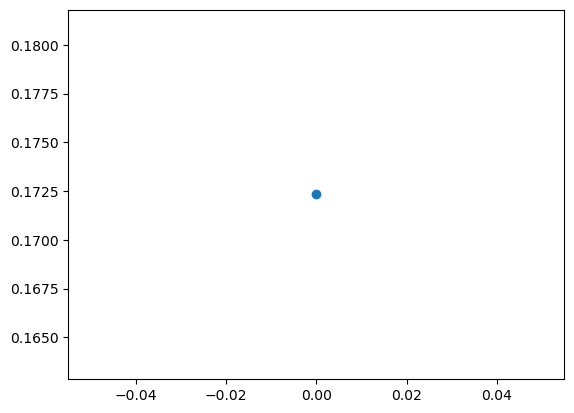

  2%|█▌                                                                                 | 1/55 [00:00<00:37,  1.45it/s]

 Shape New Array (310, 2) (310, 2)
Reprojection Error:  1.500795611286321


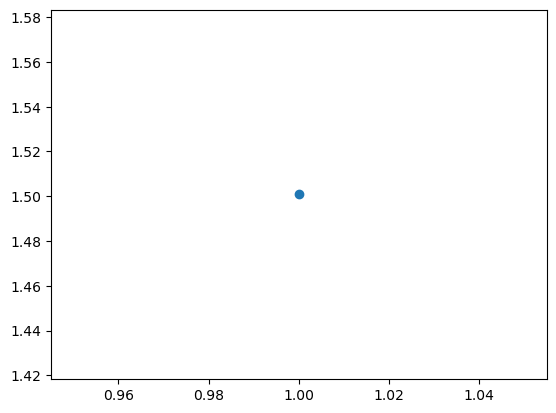

  4%|███                                                                                | 2/55 [00:01<00:38,  1.36it/s]

 Shape New Array (363, 2) (363, 2)
Reprojection Error:  10.040346541988566


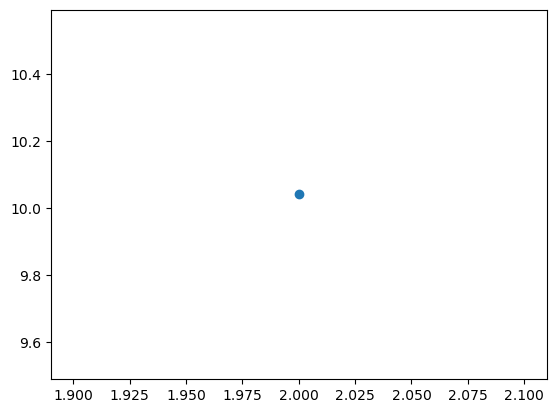

  5%|████▌                                                                              | 3/55 [00:02<00:36,  1.43it/s]

 Shape New Array (381, 2) (381, 2)
Reprojection Error:  1.7976109008754142


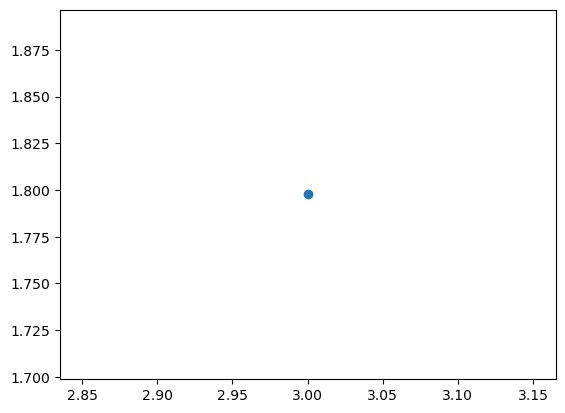

  7%|██████                                                                             | 4/55 [00:02<00:35,  1.45it/s]

 Shape New Array (600, 2) (600, 2)
Reprojection Error:  0.8664183355296378


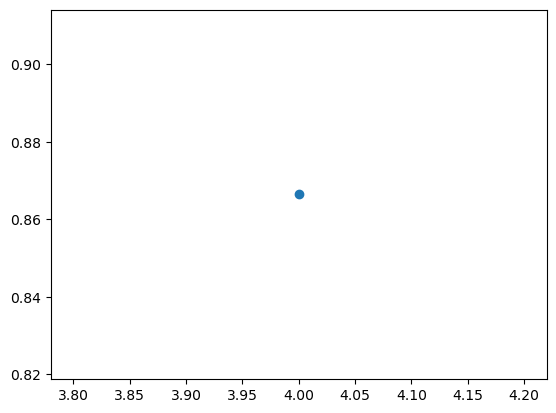

  9%|███████▌                                                                           | 5/55 [00:03<00:33,  1.47it/s]

 Shape New Array (219, 2) (219, 2)
Reprojection Error:  10.82291544623198


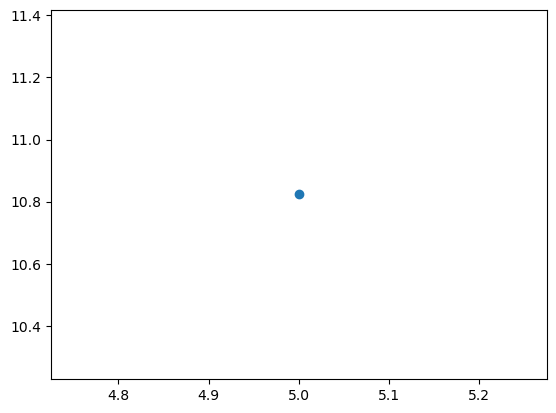

 11%|█████████                                                                          | 6/55 [00:04<00:33,  1.45it/s]

 Shape New Array (498, 2) (498, 2)
Reprojection Error:  1.5473732119282644


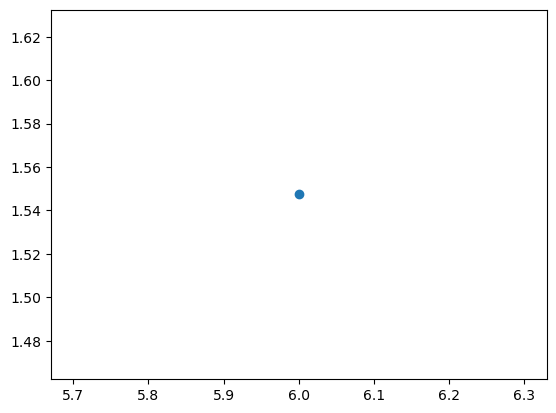

 13%|██████████▌                                                                        | 7/55 [00:04<00:33,  1.42it/s]

 Shape New Array (239, 2) (239, 2)
Reprojection Error:  6.474488654118856


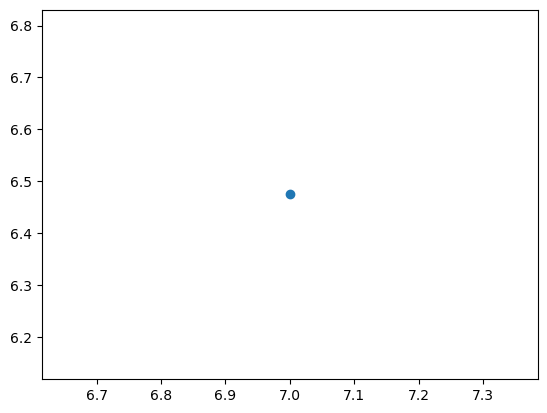

 15%|████████████                                                                       | 8/55 [00:05<00:33,  1.41it/s]

 Shape New Array (339, 2) (339, 2)
Reprojection Error:  0.32916750291700897


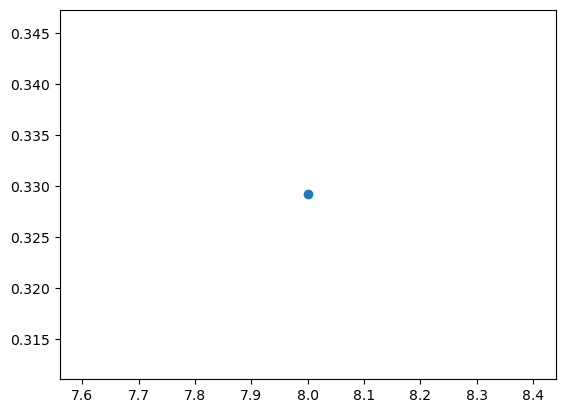

 16%|█████████████▌                                                                     | 9/55 [00:06<00:31,  1.47it/s]

 Shape New Array (280, 2) (280, 2)
Reprojection Error:  3.7129155422086018


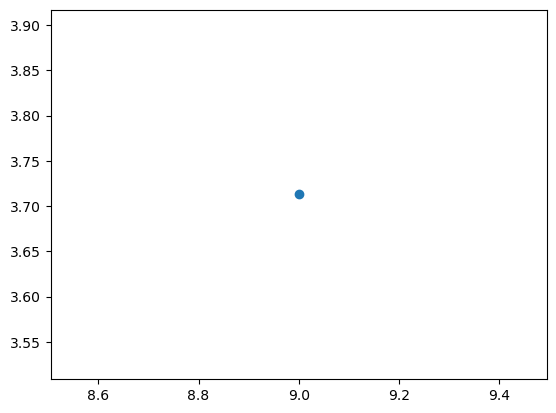

 18%|██████████████▉                                                                   | 10/55 [00:06<00:31,  1.43it/s]

 Shape New Array (316, 2) (316, 2)
Reprojection Error:  3.951434379161729


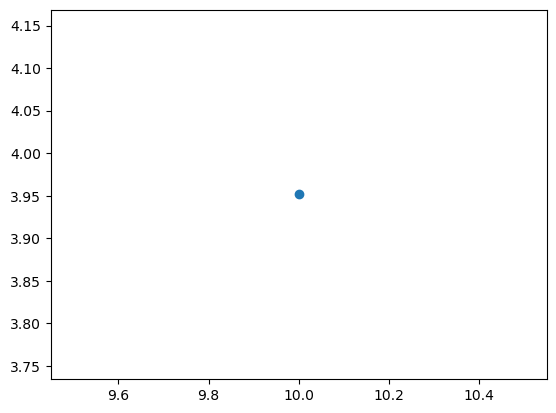

 20%|████████████████▍                                                                 | 11/55 [00:07<00:30,  1.43it/s]

 Shape New Array (246, 2) (246, 2)
Reprojection Error:  4.620271406750563


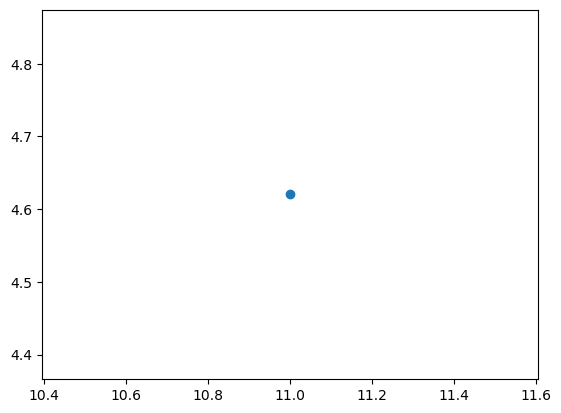

 22%|█████████████████▉                                                                | 12/55 [00:08<00:29,  1.45it/s]

 Shape New Array (285, 2) (285, 2)
Reprojection Error:  2.855962070992884


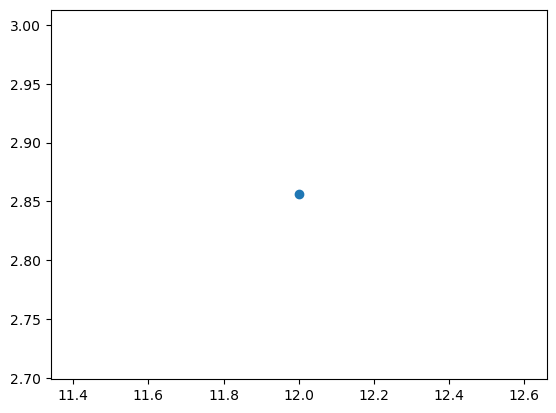

 24%|███████████████████▍                                                              | 13/55 [00:09<00:30,  1.36it/s]

 Shape New Array (330, 2) (330, 2)
Reprojection Error:  12.28831610900327


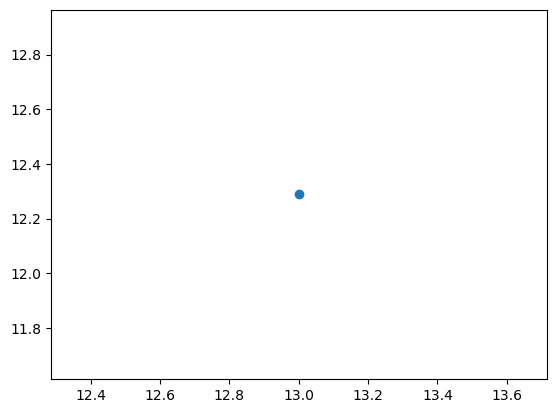

 25%|████████████████████▊                                                             | 14/55 [00:10<00:33,  1.22it/s]

 Shape New Array (377, 2) (377, 2)
Reprojection Error:  2.600065844472896


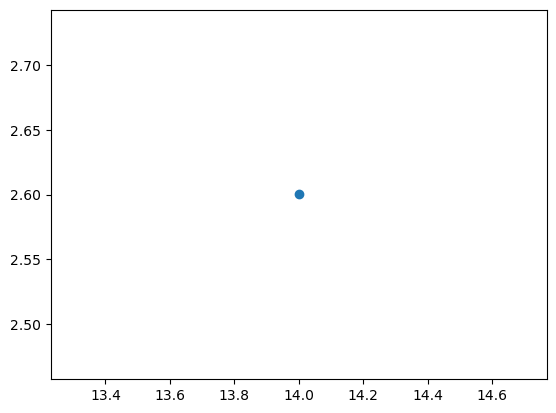

 27%|██████████████████████▎                                                           | 15/55 [00:10<00:30,  1.31it/s]

 Shape New Array (412, 2) (412, 2)
Reprojection Error:  6.560318954050435


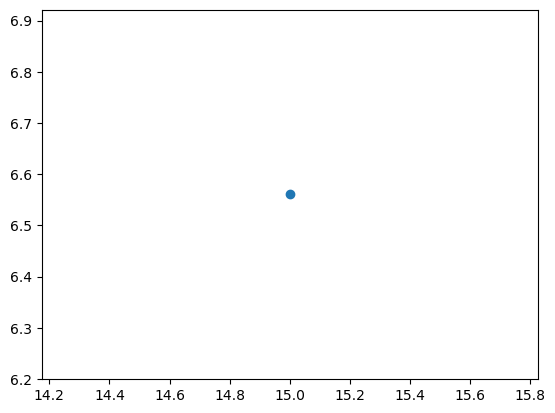

 29%|███████████████████████▊                                                          | 16/55 [00:11<00:28,  1.36it/s]

 Shape New Array (247, 2) (247, 2)
Reprojection Error:  5.75653679333878


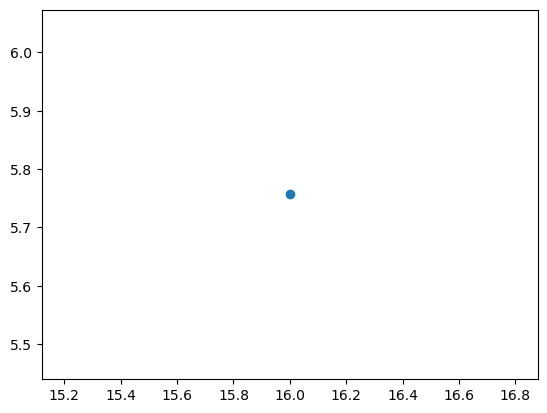

 31%|█████████████████████████▎                                                        | 17/55 [00:12<00:26,  1.41it/s]

 Shape New Array (404, 2) (404, 2)
Reprojection Error:  3.8027833438151872


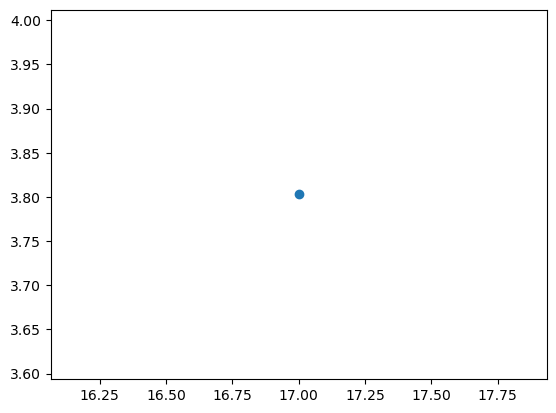

 33%|██████████████████████████▊                                                       | 18/55 [00:12<00:25,  1.45it/s]

 Shape New Array (460, 2) (460, 2)
Reprojection Error:  4.319092261809235


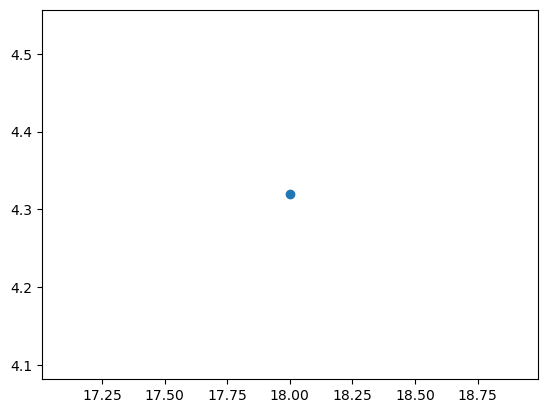

 35%|████████████████████████████▎                                                     | 19/55 [00:13<00:24,  1.44it/s]

 Shape New Array (244, 2) (244, 2)
Reprojection Error:  6.291379158297009


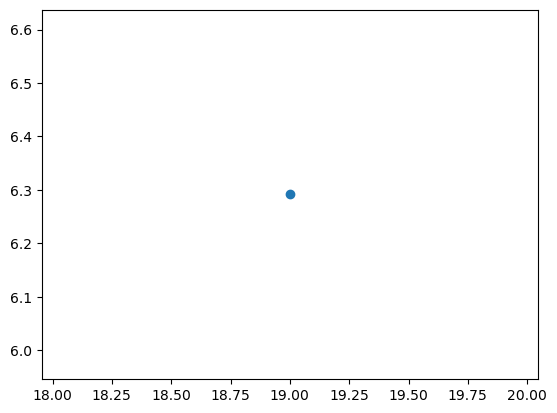

 36%|█████████████████████████████▊                                                    | 20/55 [00:14<00:23,  1.46it/s]

 Shape New Array (458, 2) (458, 2)
Reprojection Error:  2.221018294499672


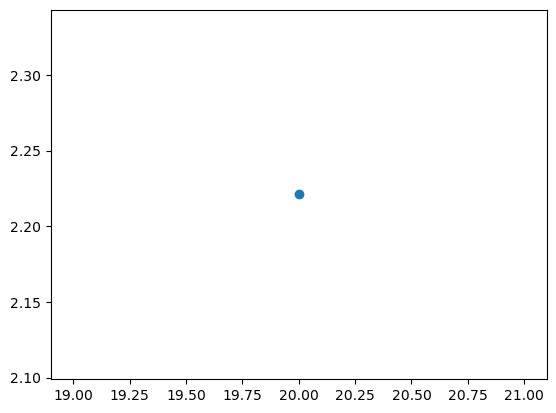

 38%|███████████████████████████████▎                                                  | 21/55 [00:14<00:22,  1.49it/s]

 Shape New Array (266, 2) (266, 2)
Reprojection Error:  5.7238240637150595


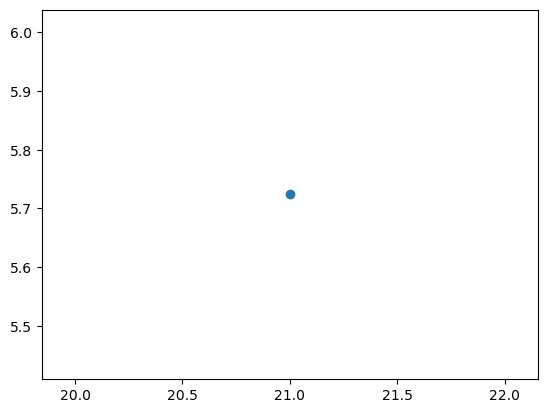

 40%|████████████████████████████████▊                                                 | 22/55 [00:15<00:21,  1.53it/s]

 Shape New Array (419, 2) (419, 2)
Reprojection Error:  5.697122515729086


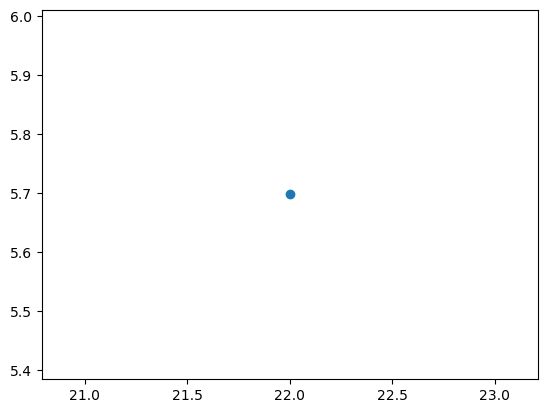

 42%|██████████████████████████████████▎                                               | 23/55 [00:16<00:20,  1.55it/s]

 Shape New Array (338, 2) (338, 2)
Reprojection Error:  19.05568299961591


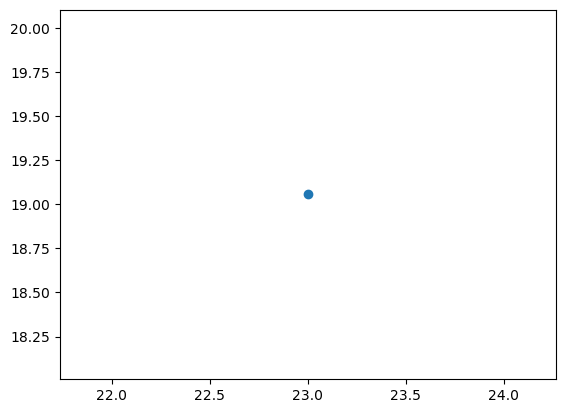

 44%|███████████████████████████████████▊                                              | 24/55 [00:16<00:19,  1.56it/s]

 Shape New Array (401, 2) (401, 2)
Reprojection Error:  13.8589606517883


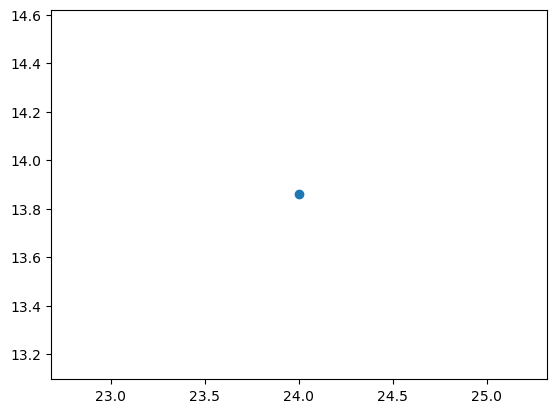

 45%|█████████████████████████████████████▎                                            | 25/55 [00:17<00:19,  1.57it/s]

 Shape New Array (332, 2) (332, 2)
Reprojection Error:  158.7940953992964


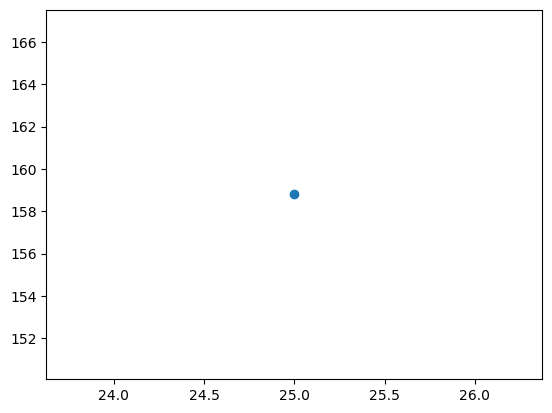

 47%|██████████████████████████████████████▊                                           | 26/55 [00:17<00:18,  1.57it/s]

 Shape New Array (368, 2) (368, 2)
Reprojection Error:  3.9175123827476996


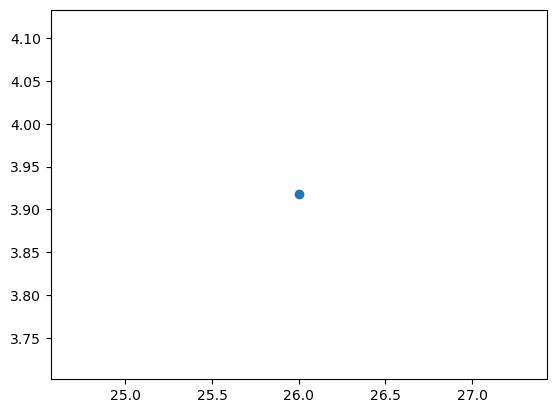

 49%|████████████████████████████████████████▎                                         | 27/55 [00:18<00:17,  1.58it/s]

 Shape New Array (469, 2) (469, 2)
Reprojection Error:  7.214075557997337


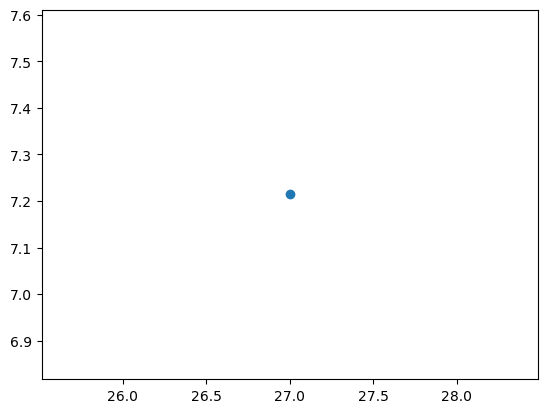

 51%|█████████████████████████████████████████▋                                        | 28/55 [00:19<00:17,  1.58it/s]

 Shape New Array (285, 2) (285, 2)
Reprojection Error:  17.3590338594485


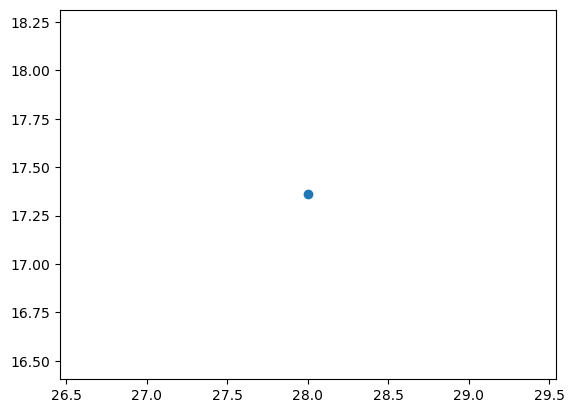

 53%|███████████████████████████████████████████▏                                      | 29/55 [00:19<00:16,  1.56it/s]

 Shape New Array (395, 2) (395, 2)
Reprojection Error:  1.6547905382052797


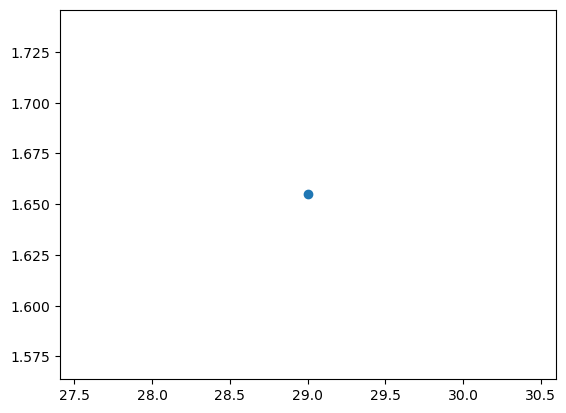

 55%|████████████████████████████████████████████▋                                     | 30/55 [00:20<00:15,  1.57it/s]

 Shape New Array (338, 2) (338, 2)
Reprojection Error:  21.449370473360958


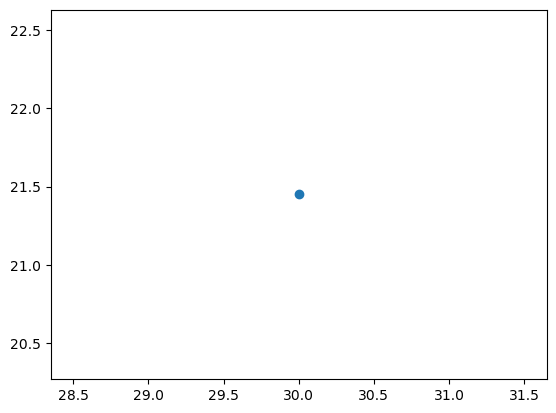

 56%|██████████████████████████████████████████████▏                                   | 31/55 [00:21<00:15,  1.56it/s]

 Shape New Array (313, 2) (313, 2)
Reprojection Error:  0.0692352554713469


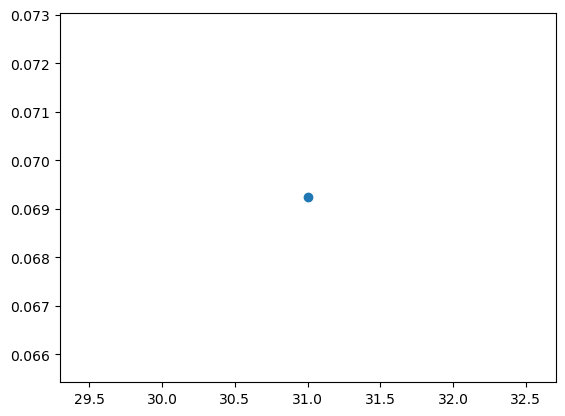

 58%|███████████████████████████████████████████████▋                                  | 32/55 [00:21<00:14,  1.54it/s]

 Shape New Array (312, 2) (312, 2)
Reprojection Error:  4.574014368062965


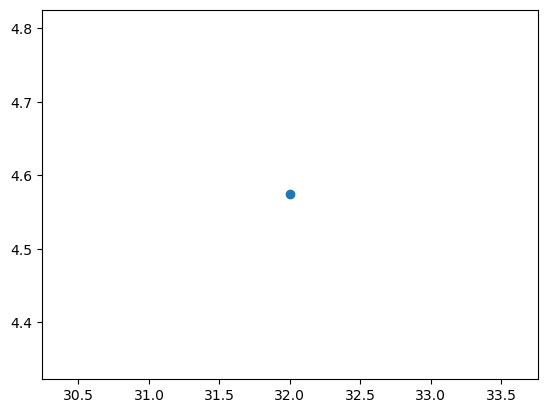

 60%|█████████████████████████████████████████████████▏                                | 33/55 [00:22<00:14,  1.53it/s]

 Shape New Array (500, 2) (500, 2)
Reprojection Error:  2.929467423676775


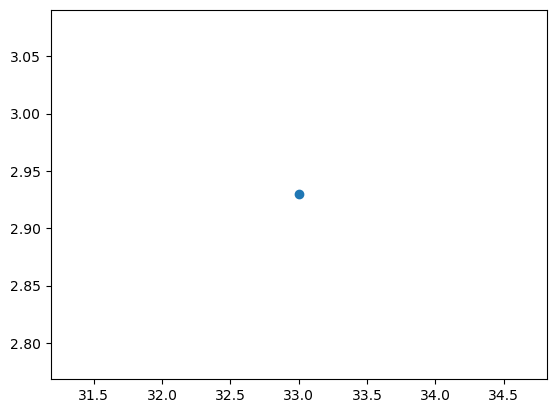

 62%|██████████████████████████████████████████████████▋                               | 34/55 [00:23<00:13,  1.53it/s]

 Shape New Array (181, 2) (181, 2)
Reprojection Error:  4.855139013434881


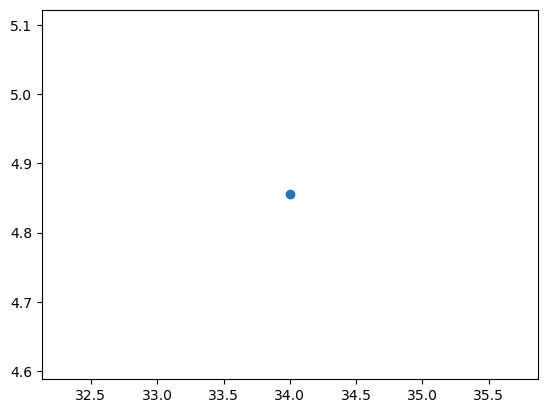

 64%|████████████████████████████████████████████████████▏                             | 35/55 [00:23<00:13,  1.53it/s]

 Shape New Array (330, 2) (330, 2)
Reprojection Error:  0.29254052429384325


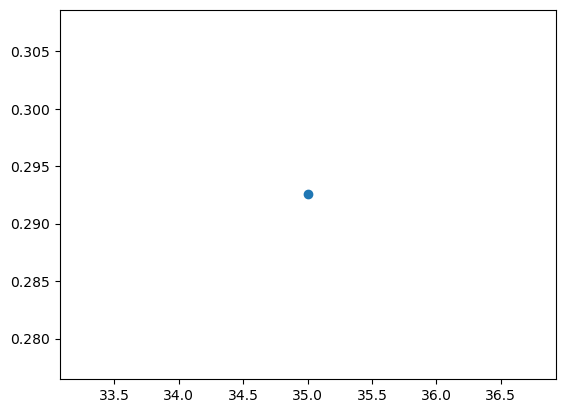

 65%|█████████████████████████████████████████████████████▋                            | 36/55 [00:24<00:12,  1.52it/s]

 Shape New Array (291, 2) (291, 2)
Reprojection Error:  0.8167787763028911


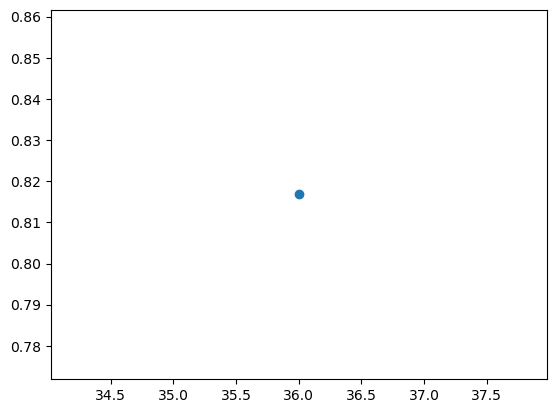

 67%|███████████████████████████████████████████████████████▏                          | 37/55 [00:25<00:11,  1.52it/s]

 Shape New Array (285, 2) (285, 2)
Reprojection Error:  2.0649747030800865


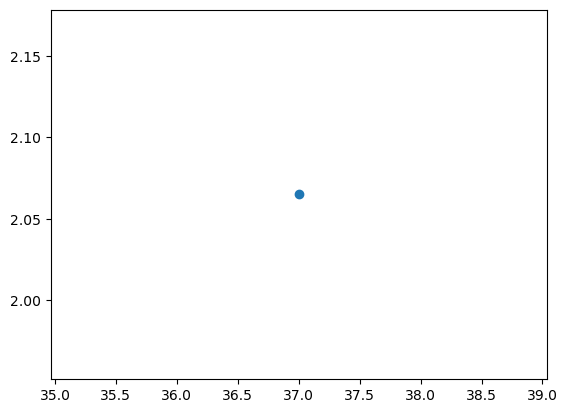

 69%|████████████████████████████████████████████████████████▋                         | 38/55 [00:25<00:11,  1.53it/s]

 Shape New Array (448, 2) (448, 2)
Reprojection Error:  2.6989481301207934


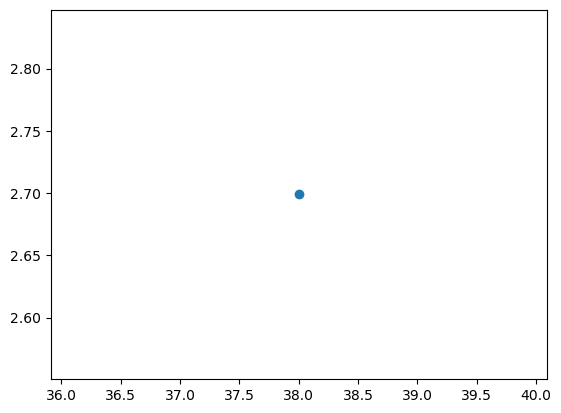

 71%|██████████████████████████████████████████████████████████▏                       | 39/55 [00:26<00:10,  1.54it/s]

 Shape New Array (253, 2) (253, 2)
Reprojection Error:  1.4378819241939602


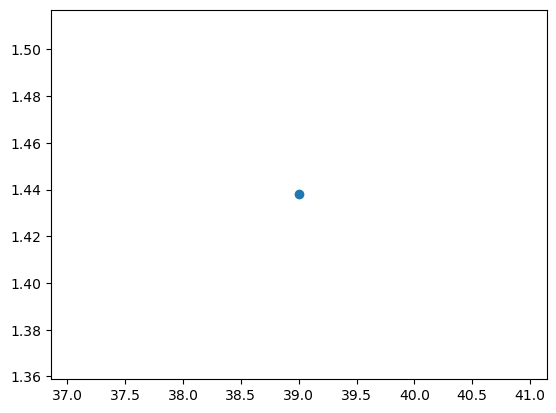

 73%|███████████████████████████████████████████████████████████▋                      | 40/55 [00:27<00:09,  1.51it/s]

 Shape New Array (324, 2) (324, 2)
Reprojection Error:  2.9970898583349084


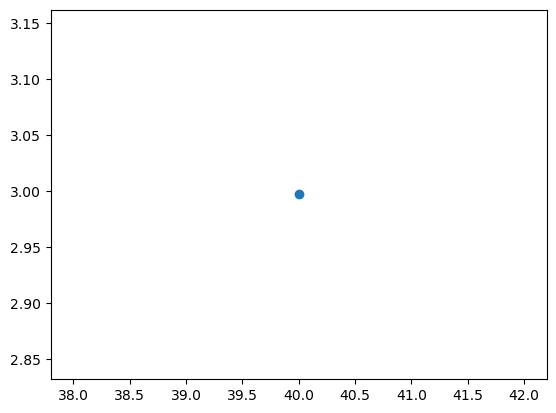

 75%|█████████████████████████████████████████████████████████████▏                    | 41/55 [00:27<00:09,  1.53it/s]

 Shape New Array (370, 2) (370, 2)
Reprojection Error:  1.3870709349069348


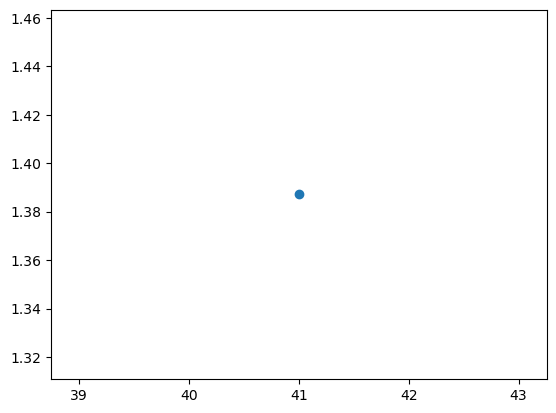

 76%|██████████████████████████████████████████████████████████████▌                   | 42/55 [00:28<00:08,  1.53it/s]

 Shape New Array (315, 2) (315, 2)
Reprojection Error:  32.063020762744955


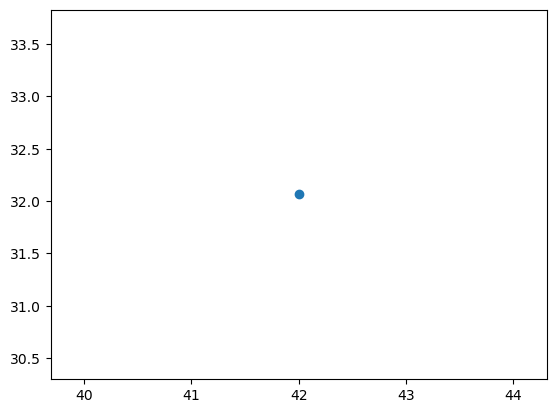

 78%|████████████████████████████████████████████████████████████████                  | 43/55 [00:28<00:07,  1.56it/s]

 Shape New Array (366, 2) (366, 2)
Reprojection Error:  10.388843621898644


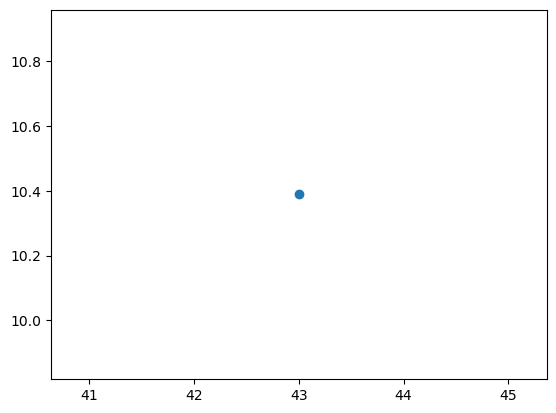

 80%|█████████████████████████████████████████████████████████████████▌                | 44/55 [00:29<00:07,  1.55it/s]

 Shape New Array (345, 2) (345, 2)
Reprojection Error:  2.1151084901872994


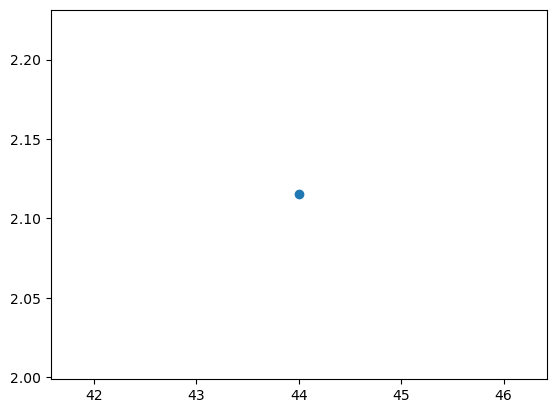

 82%|███████████████████████████████████████████████████████████████████               | 45/55 [00:30<00:06,  1.56it/s]

 Shape New Array (426, 2) (426, 2)
Reprojection Error:  0.24238927105215666


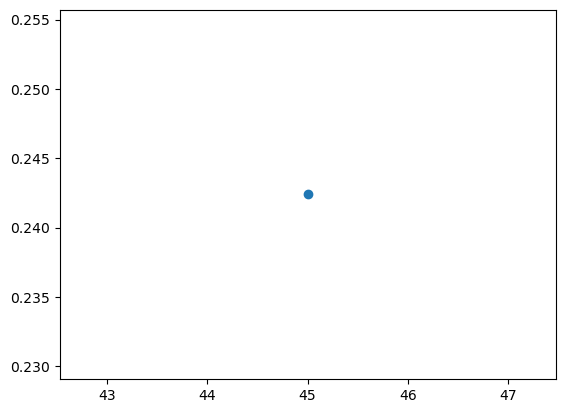

 84%|████████████████████████████████████████████████████████████████████▌             | 46/55 [00:30<00:05,  1.54it/s]

 Shape New Array (495, 2) (495, 2)
Reprojection Error:  1.75536743739566


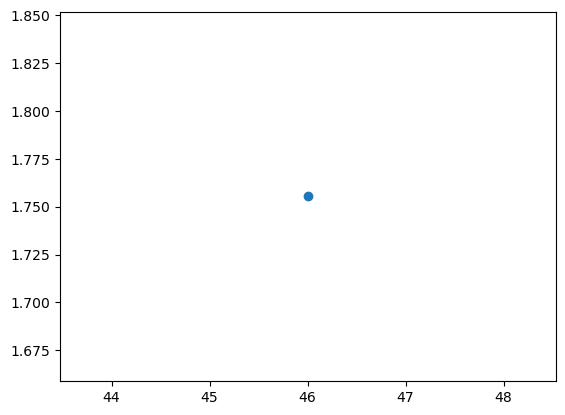

 85%|██████████████████████████████████████████████████████████████████████            | 47/55 [00:31<00:05,  1.53it/s]

 Shape New Array (630, 2) (630, 2)
Reprojection Error:  1.9133158229736766


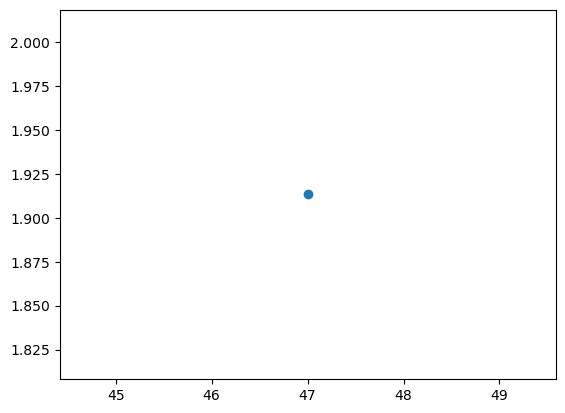

 87%|███████████████████████████████████████████████████████████████████████▌          | 48/55 [00:32<00:04,  1.50it/s]

 Shape New Array (306, 2) (306, 2)
Reprojection Error:  4.795701125158485


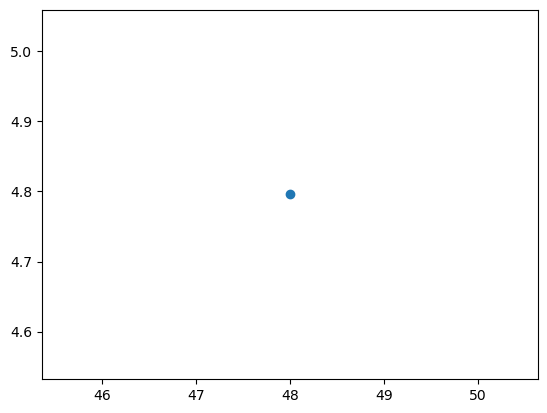

 89%|█████████████████████████████████████████████████████████████████████████         | 49/55 [00:32<00:04,  1.49it/s]

 Shape New Array (502, 2) (502, 2)
Reprojection Error:  0.908309505696246


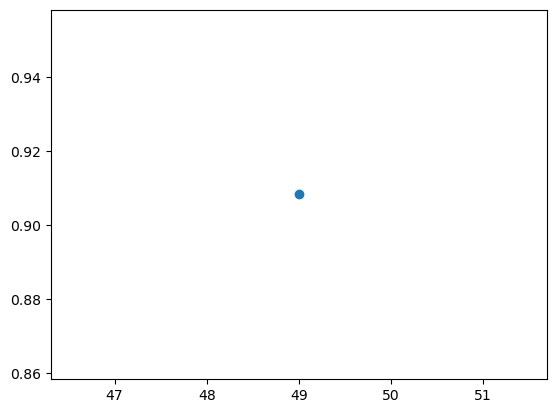

 91%|██████████████████████████████████████████████████████████████████████████▌       | 50/55 [00:33<00:03,  1.51it/s]

 Shape New Array (503, 2) (503, 2)
Reprojection Error:  1.6238297308165743


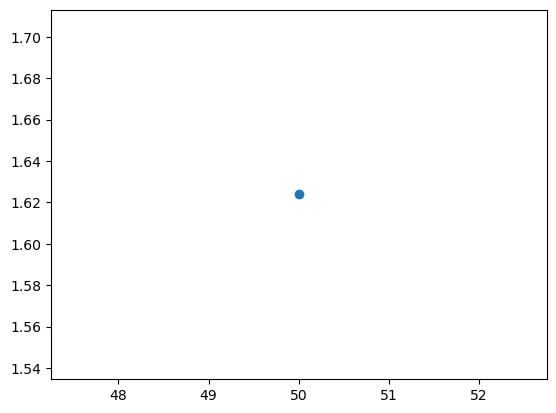

 93%|████████████████████████████████████████████████████████████████████████████      | 51/55 [00:34<00:02,  1.50it/s]

 Shape New Array (475, 2) (475, 2)
Reprojection Error:  1.314548004771508


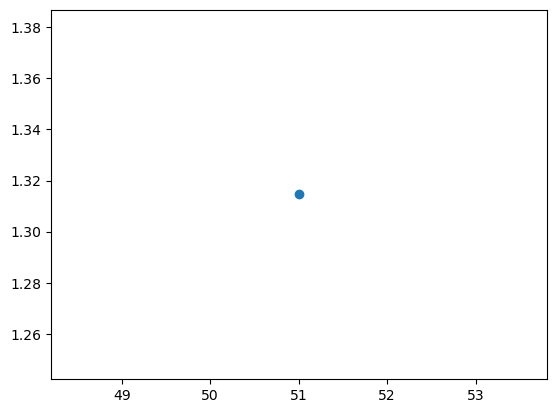

 95%|█████████████████████████████████████████████████████████████████████████████▌    | 52/55 [00:34<00:02,  1.48it/s]

 Shape New Array (448, 2) (448, 2)
Reprojection Error:  0.8802469366820427


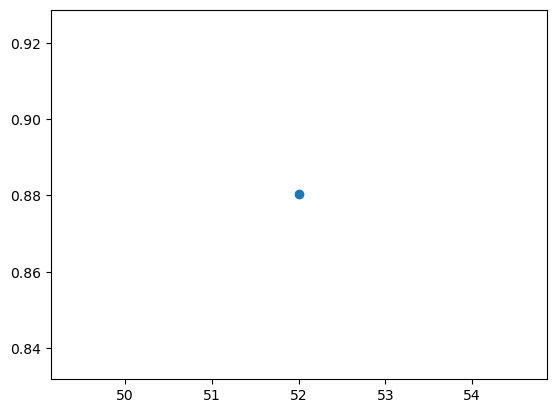

 96%|███████████████████████████████████████████████████████████████████████████████   | 53/55 [00:35<00:01,  1.48it/s]

 Shape New Array (433, 2) (433, 2)
Reprojection Error:  0.36799400811646493


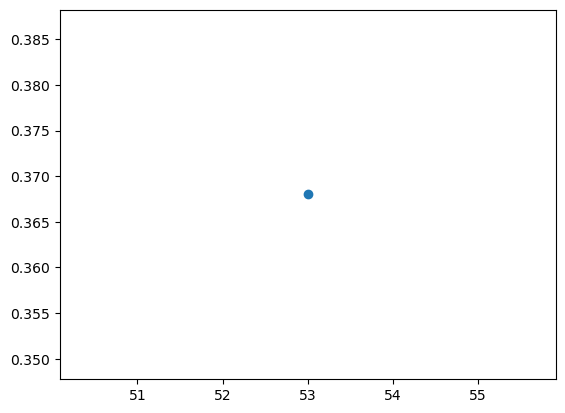

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 54/55 [00:36<00:00,  1.51it/s]

 Shape New Array (460, 2) (460, 2)
Reprojection Error:  0.34061974525641475


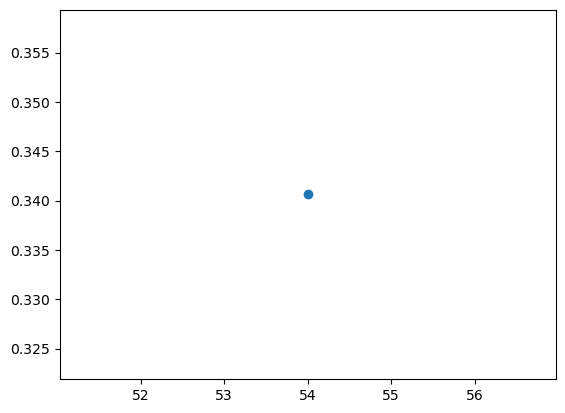

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:36<00:00,  1.49it/s]


Printing to .ply file
(20489, 3) (20489, 3)
(20489, 3) (20489, 3)
Completed Exiting ...


In [7]:
if __name__ == '__main__':
    sfm = Sfm("Datasets\\GustavIIAdolf")
    sfm()
